# Import Lib

In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout,  Activation, Flatten, Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential

from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow import keras
import plotly.graph_objects as go

from google.colab import drive
import os

# PATH

In [28]:
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/')

project_path = "Report_DBA/"
source_path = project_path + "source/"
data_path = project_path + "data/BTC-USD.csv"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [29]:
df = pd.read_csv(data_path)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1822,04/22/2023,27265.89453,27872.14258,27169.57031,27817.50000,27817.50000,1.312573e+10
1823,04/23/2023,27816.14453,27820.24414,27400.31445,27591.38477,27591.38477,1.278545e+10
1824,04/24/2023,27591.73047,27979.98242,27070.84961,27525.33984,27525.33984,1.770329e+10
1825,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1826,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Preprocessing

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   Open       1825 non-null   float64
 2   High       1825 non-null   float64
 3   Low        1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Adj Close  1825 non-null   float64
 6   Volume     1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 100.0+ KB


Nhận thấy dữ liệu có 1827 dòng nhưng có 2 dòng bị thiếu ==> Vậy nên cần xử lý các dòng đó

In [31]:
# do 2 dòng này nằm cuối dữ liệu nên không cần tìm giá trị thay thế mà trực tiếp loại bỏ
df.dropna(inplace=True)

# Plot

In [32]:
fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'], high=df['High'],
                low=df['Low'], close=df['Close'])
                     ])

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

# Train Test vs Validation Split

In [33]:
n_observations = df.shape[0]
features = ["Open", "High", "Low", "Volume", "Adj Close"]

df = df[ features]
train = df[:int(n_observations*0.7)]
test = df[int(n_observations*0.7): int(n_observations*0.9)]
val = df[int(n_observations*0.9):]

# Helper Functions

In [34]:
def to_supervised(data, lookback = 3):
    n = data.shape[0]
    X, y = list(), list()
    for i in range(n - lookback):
        X.append(data[i: i + lookback])
        y.append(data[i+lookback, -1])
    return np.array(X), np.array(y)

# Main Run

## Prepare data

In [35]:
scaler = MinMaxScaler().fit(train)
y_scaler = MinMaxScaler().fit(train.values[:, -1].reshape(-1, 1))
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)
val_scaled = scaler.transform(val)

train_X, train_y= to_supervised(train_scaled, 3)
test_X, test_y = to_supervised(test_scaled, 3)
val_X, val_y = to_supervised(val_scaled, 3)

## Seq2Seq Model

In [36]:
n_past = 3
n_features = 5
n_future = 1

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(128, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(128, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 3, 5)]       0           []                               
                                                                                                  
 lstm_14 (LSTM)                 [(None, 128),        68608       ['input_6[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                                  
 repeat_vector_5 (RepeatVector)  (None, 1, 128)      0           ['lstm_14[0][0]']                
                                                                                            

In [37]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(128,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(128, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(128, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(128, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 3, 5)]       0           []                               
                                                                                                  
 lstm_16 (LSTM)                 [(None, 3, 128),     68608       ['input_7[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                                  
 lstm_17 (LSTM)                 [(None, 128),        131584      ['lstm_16[0][0]']                
                                 (None, 128),                                               

## Train data

In [38]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model_e1d1.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss='mse')

history_e1d1=model_e1d1.fit(
    train_X, train_y.reshape(-1,1,1),
    epochs=200,
    validation_data=(val_X,val_y.reshape(-1,1,1)),
    batch_size=32,
    verbose=0,
    callbacks=[reduce_lr])

In [39]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model_e2d2.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss='mse')

history_e2d2 = model_e2d2.fit(
    train_X, train_y.reshape(-1,1,1),
    epochs=200,
    validation_data=(val_X,val_y.reshape(-1,1,1)),
    batch_size=32,
    verbose=0,
    callbacks=[reduce_lr])

## Test data

12/12 [==============================] - 1s 6ms/step


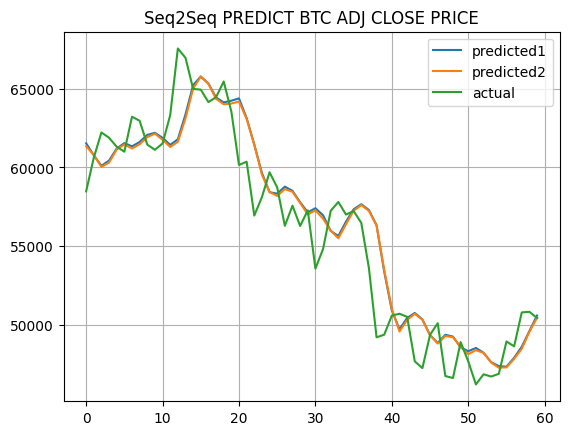

In [40]:
# number of days used for flotting
days = 60

pred = model_e1d1.predict(test_X)
pred2 = model_e2d2.predict(test_X)

# inverse data to origin values
y_predicted1 = y_scaler.inverse_transform(np.array(pred).reshape(-1, 1)).reshape(-1, )
y_predicted2 = y_scaler.inverse_transform(np.array(pred2).reshape(-1, 1)).reshape(-1, )
y_true = y_scaler.inverse_transform(np.array(test_y).reshape(-1, 1)).reshape(-1, )

# plot
plt.grid(True)
plt.plot(y_predicted1[:days], label="predicted1")
plt.plot(y_predicted2[:days], label="predicted2")
plt.plot(y_true[:days], label="actual")
plt.title("Seq2Seq PREDICT BTC ADJ CLOSE PRICE")
plt.legend()
plt.show()

In [41]:
pred.shape

(362, 1, 1)

# Evaluate


In [42]:
mae = mean_absolute_error(y_true, y_predicted1)
rmse = np.sqrt(mean_squared_error(y_true, y_predicted1))
mape = mean_absolute_percentage_error(y_true, y_predicted1)
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"mape: {mape}")

MAE: 1279.2222189692677
RMSE: 1760.1671925792245
mape: 0.037839832194471866


In [43]:
mae = mean_absolute_error(y_true, y_predicted2)
rmse = np.sqrt(mean_squared_error(y_true, y_predicted2))
mape = mean_absolute_percentage_error(y_true, y_predicted2)
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"mape: {mape}")

MAE: 1284.6408135445438
RMSE: 1764.3092349402077
mape: 0.03813264218068016


In [44]:
y_true[0]

58482.38672

In [45]:
y_predicted1[0]

61538.73

In [46]:
y_predicted2[0]

61351.297